In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
import torchvision
torchvision.ops.sigmoid_focal_loss

<function torchvision.ops.focal_loss.sigmoid_focal_loss(inputs: torch.Tensor, targets: torch.Tensor, alpha: float = 0.25, gamma: float = 2, reduction: str = 'none') -> torch.Tensor>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
brset_embed = pd.read_csv('/content/drive/MyDrive/mlhc_project/embeddings.csv')

In [6]:
text_column_names = brset_embed.columns[brset_embed.columns.str.match('text_\d+')]
image_column_names = brset_embed.columns[brset_embed.columns.str.match('image_\d+')]
text_columns = brset_embed[text_column_names]
image_columns = brset_embed[image_column_names]

In [7]:
text_embed = torch.tensor(text_columns.values)
image_embed = torch.tensor(image_columns.values)
y = torch.tensor(brset_embed['DR_2'].values)

### Text Only Model

In [25]:
list_of_models = [
    nn.Sequential(
    nn.Linear(4096, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(4096, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

]

In [26]:
train_idx = brset_embed[brset_embed['split'] == 'train'].index
test_idx = brset_embed[brset_embed['split'] == 'test'].index

text_train = text_embed[train_idx]
text_test = text_embed[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

In [27]:
# create a dataset and dataloader for text only
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

text_train_dataset = SimpleDataset(text_train, y_train)
text_test_dataset = SimpleDataset(text_test, y_test)

text_train_loader = DataLoader(text_train_dataset, batch_size=32, shuffle=True)
text_test_loader = DataLoader(text_test_dataset, batch_size=32, shuffle=False)

In [28]:
def train(model, train_loader, test_loader, criterion, optimizer,focal=False, num_epochs=10):
    list_loss_train,list_loss_test,list_acc_train,list_acc_test,list_auc_train,list_auc_test,list_f1_train,list_f1_test=[],[],[],[],[],[],[],[]
    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        epoch_loss_train = 0
        y_pred,y_label = torch.tensor([]),torch.tensor([])
        for X, y in train_loader:
            X = X.to(device).float()
            y = y.to(device).float()
            optimizer.zero_grad()
            y_hat = model(X)
            # print(torchvision.ops.sigmoid_focal_loss(y_hat,y.unsqueeze(1)))
            if focal:
              loss = criterion(y_hat, y.unsqueeze(1)
              ,reduction='mean'
              )
            else:
              loss = criterion(y_hat, y.unsqueeze(1))


            loss.backward()
            epoch_loss_train += loss.item()/len(train_loader)
            y_pred = torch.cat((y_pred.to(device), model(X).detach().to(device)))
            y_label = torch.cat((y_label.to(device), y.unsqueeze(1).to(device)))
            optimizer.step()
        # Probably would be more meaningful to use a validation set
        auc_train = roc_auc_score(y_label.cpu().numpy(), y_pred.cpu().numpy())
        accuracy_train = accuracy_score(y_label.cpu().numpy(), y_pred.cpu().numpy() > 0.5)
        f1_train = f1_score(y_label.cpu().numpy(), y_pred.cpu().numpy() > 0.5)
        # print(f'Train Epoch {epoch} Loss: {epoch_loss}, AUC: {auc}, Accuracy: {accuracy}, F1: {f1}')
        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():
            y_hat = torch.tensor([]).to(device)
            y_true = torch.tensor([]).to(device)
            for X, y in test_loader:
                X = X.to(device).float()
                y = y.to(device).float()
                y_out = model(X)
                y_hat = torch.cat((y_hat, y_out))
                y_true = torch.cat((y_true, y.unsqueeze(1)))
                if focal:
                  loss = criterion(y_out, y.unsqueeze(1)
                  ,reduction='mean'
                  )
                else:
                  loss = criterion(y_out, y.unsqueeze(1))
                # loss = criterion(y_hat, y.unsqueeze(1))
                epoch_loss_test += loss.item()/len(test_loader)
            auc_test = roc_auc_score(y_true.cpu().numpy(), y_hat.cpu().numpy())
            accuracy_test = accuracy_score(y_true.cpu().numpy(), y_hat.cpu().numpy() > 0.5)
            f1_test = f1_score(y_true.cpu().numpy(), y_hat.cpu().numpy() > 0.5)
        list_loss_train.append(epoch_loss_train)
        list_loss_test.append(epoch_loss_test)
        list_auc_train.append(auc_train)
        list_auc_test.append(auc_test)
        list_f1_train.append(f1_train)
        list_f1_test.append(f1_test)
        list_acc_train.append(accuracy_train)
        list_acc_test.append(accuracy_test)


        print(f'Test Epoch {epoch} Loss_train: {epoch_loss_train}, Loss_test: {epoch_loss_test}, AUC train: {auc_train}, AUC test: {auc_test}, Accuracy train: {accuracy_train}, Accuracy test: {accuracy_test} F1 train: {f1_train}, F1 test: {f1_test}')
    return {
        "list_loss_train":list_loss_train,
        "list_loss_test":list_loss_test,
        "list_acc_train":list_acc_train,
        "list_acc_test":list_acc_test,
        "list_auc_train":list_auc_train,
        "list_auc_test":list_auc_test,
        "list_f1_train":list_f1_train,
        "list_f1_test":list_f1_test
    }

def get_predicted_probs(model, loader):
    model.eval()
    model.to(device)
    y_hat = torch.tensor([]).to(device)
    with torch.no_grad():
        for X,_ in loader:
            X = X.to(device).float()
            y_hat = torch.cat((y_hat, model(X)))
    return y_hat.cpu().numpy().flatten()


def plot_performance(out):
    plt.plot(out["list_acc_test"],label="list_acc_test")
    plt.plot(out["list_acc_train"],label="list_acc_train")
    plt.legend()
    plt.show()

    plt.plot(out["list_loss_train"],label="list_loss_train")
    plt.plot(out["list_loss_test"],label="list_loss_test")
    plt.legend()
    plt.show()

    plt.plot(out["list_auc_train"],label="list_auc_train")
    plt.plot(out["list_auc_test"],label="list_auc_test")
    plt.legend()
    plt.show()

    plt.plot(out["list_f1_test"],label="list_f1_test")
    plt.plot(out["list_f1_train"],label="list_f1_train")
    plt.legend()
    plt.show()

In [29]:
total_params = sum(p.numel() for p in list_of_models[3].parameters())
total_params

5507585

In [30]:
import matplotlib.pyplot as plt
import json
text_json = {}
for aModelIndex in range(4):
    aModel = list_of_models[aModelIndex]
    num_params = sum(p.numel() for p in aModel.parameters())
    print(num_params)
    for aCriterionIndex in range(2):
        if aCriterionIndex==0:
            loss = 'bce'
            optimizer = optim.Adam(aModel.parameters(), lr=0.001)
            out = train(aModel, text_train_loader, text_test_loader, nn.BCELoss(), optimizer, focal=False, num_epochs=20)
        if aCriterionIndex==1:
            loss = 'focal'
            optimizer = optim.Adam(aModel.parameters(), lr=0.001)
            out = train(aModel, text_train_loader, text_test_loader, torchvision.ops.sigmoid_focal_loss, optimizer, focal=True, num_epochs=20)
        text_json[f"Model_{aModelIndex}_loss_{loss}"]={
            "output":out,
            "num_params":num_params
        }
json.dump(text_json,open('text_json','w'))


# criterion = nn.BCELoss()
# criterion = torchvision.ops.sigmoid_focal_loss
# optimizer = optim.Adam(list_of_models[0].parameters(), lr=0.001)
# out = train(list_of_models[0], text_train_loader, text_test_loader, criterion, optimizer, focal=True,num_epochs=20)
# plot_performance(out)

4097
Test Epoch 0 Loss_train: 0.18150971723700648, Loss_test: 0.092062866543511, AUC train: 0.8559883339501599, AUC test: 0.9692830877485894, Accuracy train: 0.9455118352290194, Accuracy test: 0.9732636754763369 F1 train: 0.42404549147034926, F1 test: 0.7830423940149627
Test Epoch 1 Loss_train: 0.10163859458893647, Loss_test: 0.07377747118966108, AUC train: 0.9535385510229192, AUC test: 0.9680402384152581, Accuracy train: 0.9658007992622195, Accuracy test: 0.9803318992009834 F1 train: 0.6937370956641431, F1 test: 0.8358974358974359
Test Epoch 2 Loss_train: 0.09610065928463259, Loss_test: 0.12688089722174556, AUC train: 0.9557740089474731, AUC test: 0.9688470002632099, Accuracy train: 0.9700276667691362, Accuracy test: 0.9625076828518746 F1 train: 0.7427440633245382, F1 test: 0.5960264900662252
Test Epoch 3 Loss_train: 0.09291084587481907, Loss_test: 0.08125601191639752, AUC train: 0.9592516473164633, AUC test: 0.9675216057987175, Accuracy train: 0.9724100830003074, Accuracy test: 0.978

In [31]:
import matplotlib.pyplot as plt




In [ ]:
# # Evaluate text only model on test set
# y_pred_probs = get_predicted_probs(text_only_model, text_test_loader)
# y_preds = (np.array(y_pred_probs) > 0.5).astype(int)
# text_only_roc = roc_auc_score(y_test.numpy(), y_pred_probs)
# text_only_accuracy = accuracy_score(y_test.numpy(), y_preds)
# text_only_f1 = f1_score(y_test.numpy(), y_preds)
# print(f'Text Only ROC: {text_only_roc}, Accuracy: {text_only_accuracy}, F1: {text_only_f1}')

### Image Only model

In [32]:
# Train image only model
# image_only_model = nn.Sequential(
#     nn.Linear(1536, 256),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(256, 1),
#     nn.Sigmoid()
# )

list_of_models = [
    nn.Sequential(
    nn.Linear(1536, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(1536, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(1536, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(1536, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)


]



image_train = image_embed[train_idx]
image_test = image_embed[test_idx]

image_train_dataset = SimpleDataset(image_train, y_train)
image_test_dataset = SimpleDataset(image_test, y_test)

image_train_loader = DataLoader(image_train_dataset, batch_size=32, shuffle=True)
image_test_loader = DataLoader(image_test_dataset, batch_size=32, shuffle=False)

In [33]:
criterion = nn.BCELoss()
criterion = torchvision.ops.sigmoid_focal_loss


import matplotlib.pyplot as plt
import json
text_json = {}
for aModelIndex in range(4):
    aModel = list_of_models[aModelIndex]
    num_params = sum(p.numel() for p in aModel.parameters())
    print(num_params)
    for aCriterionIndex in range(2):
        if aCriterionIndex==0:
            loss = 'bce'
            optimizer = optim.Adam(aModel.parameters(), lr=0.001)
            out = train(aModel, image_train_loader, image_test_loader, nn.BCELoss(), optimizer, focal=False, num_epochs=20)
        if aCriterionIndex==1:
            loss = 'focal'
            optimizer = optim.Adam(aModel.parameters(), lr=0.001)
            out = train(aModel, image_train_loader, image_test_loader, torchvision.ops.sigmoid_focal_loss, optimizer, focal=True, num_epochs=20)
        text_json[f"Model_{aModelIndex}_loss_{loss}"]={
            "output":out,
            "num_params":num_params
        }
json.dump(text_json,open('image_json','w'))

# optimizer = optim.Adam(image_only_model.parameters(), lr=0.001)
# out = train(image_only_model, image_train_loader, image_test_loader, criterion, optimizer, focal=True, num_epochs=20)
# plot_performance(out)

1537
Test Epoch 0 Loss_train: 0.18092493080884153, Loss_test: 0.14821590804586218, AUC train: 0.8334298371334238, AUC test: 0.9264086793869233, Accuracy train: 0.9409775591761451, Accuracy test: 0.9459127228027043 F1 train: 0.29541284403669726, F1 test: 0.3432835820895523
Test Epoch 1 Loss_train: 0.13891388216863684, Loss_test: 0.1279203116838985, AUC train: 0.9117217344616805, AUC test: 0.9360742470092964, Accuracy train: 0.9531201967414694, Accuracy test: 0.9557467732022127 F1 train: 0.5174050632911392, F1 test: 0.5414012738853504
Test Epoch 2 Loss_train: 0.12936911254169314, Loss_test: 0.12440358206410619, AUC train: 0.927447849771158, AUC test: 0.9367922339048675, Accuracy train: 0.9565785428834922, Accuracy test: 0.9600491702519975 F1 train: 0.5690312738367658, F1 test: 0.5987654320987654
Test Epoch 3 Loss_train: 0.12313220020685656, Loss_test: 0.1256753962724378, AUC train: 0.9333931193260652, AUC test: 0.9429862336525597, Accuracy train: 0.9601137411620043, Accuracy test: 0.9585

In [ ]:
# criterion = nn.BCELoss()
# criterion = torchvision.ops.sigmoid_focal_loss

# optimizer = optim.Adam(image_only_model.parameters(), lr=0.001)
# train(image_only_model, image_train_loader, image_test_loader, criterion, optimizer, num_epochs=20)

Test Epoch 0 Loss: 50.5938715338707, AUC train: 0.7692460399480017, AUC test: 0.9404662709691889, Accuracy train: 0.9393636643098678, Accuracy test: 0.9351567301782422 F1 train: 0.1377049180327869, F1 test: 0.0
Test Epoch 1 Loss: 50.58726146072149, AUC train: 0.7677697409279052, AUC test: 0.9455996436542262, Accuracy train: 0.9372886566246542, Accuracy test: 0.9351567301782422 F1 train: 0.07272727272727274, F1 test: 0.0
Test Epoch 2 Loss: 50.60610416531563, AUC train: 0.8790516398270032, AUC test: 0.9458862154303326, Accuracy train: 0.9350599446664617, Accuracy test: 0.9351567301782422 F1 train: 0.0, F1 test: 0.0
Test Epoch 3 Loss: 50.59189026802778, AUC train: 0.8553757058451347, AUC test: 0.9470153705264044, Accuracy train: 0.9356747617583769, Accuracy test: 0.9474492931776275 F1 train: 0.018757327080890975, F1 test: 0.3448275862068966
Test Epoch 4 Loss: 50.599676601588726, AUC train: 0.689541017681448, AUC test: 0.9325621852966874, Accuracy train: 0.9369043959422072, Accuracy test: 

KeyboardInterrupt: 

In [ ]:
# # Evaluate image only model on test set
# y_pred_probs = get_predicted_probs(image_only_model, image_test_loader)
# y_preds = (np.array(y_pred_probs) > 0.5).astype(int)
# image_only_roc = roc_auc_score(y_test.numpy(), y_pred_probs)
# image_only_accuracy = accuracy_score(y_test.numpy(), y_preds)
# image_only_f1 = f1_score(y_test.numpy(), y_preds)
# print(f'Image Only ROC: {image_only_roc}, Accuracy: {image_only_accuracy}, F1: {image_only_f1}')

Image Only ROC: 0.9325575129307726, Accuracy: 0.9351567301782422, F1: 0.0


### Simple Early Fusion Model

In [34]:
list_of_models = [
    nn.Sequential(
    nn.Linear(4096+1536, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(4096+1536, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(4096+1536, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
),
    nn.Sequential(
    nn.Linear(4096+1536, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)
]




combined_train = torch.cat((text_train, image_train), dim=1)
combined_test = torch.cat((text_test, image_test), dim=1)

combined_train_dataset = SimpleDataset(combined_train, y_train)
combined_test_dataset = SimpleDataset(combined_test, y_test)

combined_train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

In [35]:
# criterion = nn.BCELoss()
# criterion = torchvision.ops.sigmoid_focal_loss


criterion = nn.BCELoss()
criterion = torchvision.ops.sigmoid_focal_loss


import matplotlib.pyplot as plt
import json
text_json = {}
for aModelIndex in range(4):
    aModel = list_of_models[aModelIndex]
    num_params = sum(p.numel() for p in aModel.parameters())
    print(num_params)
    for aCriterionIndex in range(2):
        if aCriterionIndex==0:
            loss = 'bce'
            optimizer = optim.Adam(aModel.parameters(), lr=0.001)
            out = train(aModel, combined_train_loader, combined_test_loader, nn.BCELoss(), optimizer, focal=False, num_epochs=20)
        if aCriterionIndex==1:
            loss = 'focal'
            optimizer = optim.Adam(aModel.parameters(), lr=0.001)
            out = train(aModel, combined_train_loader, combined_test_loader, torchvision.ops.sigmoid_focal_loss, optimizer, focal=True, num_epochs=20)
        text_json[f"Model_{aModelIndex}_loss_{loss}"]={
            "output":out,
            "num_params":num_params
        }
json.dump(text_json,open('text_image_json','w'))

# optimizer = optim.Adam(simple_early_fusion_model.parameters(), lr=0.0001)
# out = train(simple_early_fusion_model, combined_train_loader, combined_test_loader, criterion, optimizer, num_epochs=40)
# plot_performance(out)

5633
Test Epoch 0 Loss_train: 0.1461525263235599, Loss_test: 0.07576679450678915, AUC train: 0.9050073848994006, AUC test: 0.9732164411211809, Accuracy train: 0.9543498309252997, Accuracy test: 0.9809465273509527 F1 train: 0.5638766519823789, F1 test: 0.8418367346938775
Test Epoch 1 Loss_train: 0.08768723914146612, Loss_test: 0.10158409910532193, AUC train: 0.9656648135926891, AUC test: 0.9812342210309419, Accuracy train: 0.9714878573624347, Accuracy test: 0.9701905347264905 F1 train: 0.7564018384766906, F1 test: 0.7966457023060797
Test Epoch 2 Loss_train: 0.09036580529129001, Loss_test: 0.06950501227915729, AUC train: 0.9604976697566364, AUC test: 0.9808588743024547, Accuracy train: 0.9733323086381801, Accuracy test: 0.9800245851259988 F1 train: 0.7782747603833865, F1 test: 0.8463356973995272
Test Epoch 3 Loss_train: 0.07100518852253426, Loss_test: 0.07548667066736264, AUC train: 0.9735658048762219, AUC test: 0.9782174301052995, Accuracy train: 0.9794036274208423, Accuracy test: 0.981

In [ ]:
# y_pred_probs = get_predicted_probs(simple_early_fusion_model, combined_test_loader)
# y_preds = (np.array(y_pred_probs) > 0.5).astype(int)
# early_fusion_roc = roc_auc_score(y_test.numpy(), y_pred_probs)
# early_fusion_accuracy = accuracy_score(y_test.numpy(), y_preds)
# early_fusion_f1 = f1_score(y_test.numpy(), y_preds)
# print(f'Early Fusion ROC: {early_fusion_roc}, Accuracy: {early_fusion_accuracy}, F1: {early_fusion_f1}')

### Simple Late Fusion Model

In [ ]:
# Define separate modules for text and image processing
class TextModule(nn.Module):
    def __init__(self):
        super(TextModule, self).__init__()
        self.fc1 = nn.Linear(4096, 256)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return x

class ImageModule(nn.Module):
    def __init__(self):
        super(ImageModule, self).__init__()
        self.fc1 = nn.Linear(1536, 256)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return x

class SimpleLateFusionModel(nn.Module):
    def __init__(self):
        super(SimpleLateFusionModel, self).__init__()
        self.text_module = TextModule()
        self.image_module = ImageModule()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.output = nn.Sigmoid()

    def forward(self, combined_data):
        text_data = combined_data[:, :4096]
        image_data = combined_data[:, 4096:]
        text_features = self.text_module(text_data)
        image_features = self.image_module(image_data)
        combined_features = torch.cat((text_features, image_features), dim=1)
        x = self.fc1(combined_features)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

# Instantiate and configure the model, criterion, and optimizer



Test Epoch 0 Loss_train: 0.1692850231250211, Loss_test: 0.09828358266831323, AUC train: 0.8719427318924066, AUC test: 0.9669912922673901, Accuracy train: 0.9438979403627421, Accuracy test: 0.964658881376767 F1 train: 0.29942418426103645, F1 test: 0.6417445482866043
Test Epoch 1 Loss_train: 0.09779093523237492, Loss_test: 0.07929605505812691, AUC train: 0.9618708671189846, AUC test: 0.9741119779215137, Accuracy train: 0.9661850599446664, Accuracy test: 0.9797172710510141 F1 train: 0.6923076923076923, F1 test: 0.8374384236453202
Test Epoch 2 Loss_train: 0.08125132977698203, Loss_test: 0.06726607437446422, AUC train: 0.9696591274389986, AUC test: 0.9799244011194989, Accuracy train: 0.9731786043652013, Accuracy test: 0.9824830977258758 F1 train: 0.7684140676841407, F1 test: 0.8613138686131386
Test Epoch 3 Loss_train: 0.07043053315413536, Loss_test: 0.07115784449292822, AUC train: 0.9753295240837205, AUC test: 0.9812575828605159, Accuracy train: 0.9774823240086075, Accuracy test: 0.97940995

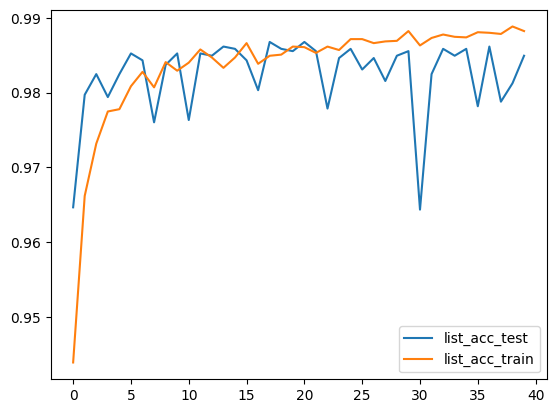

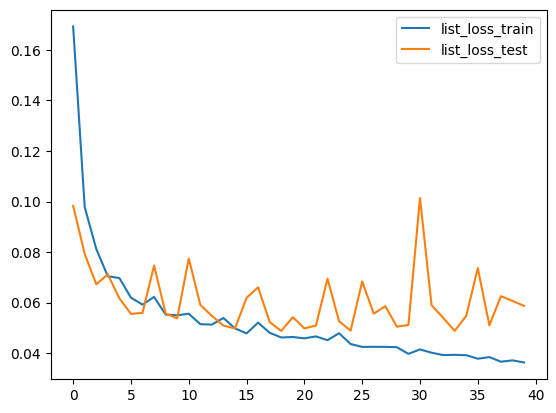

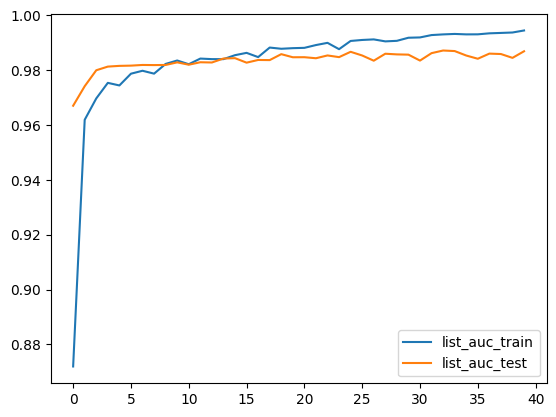

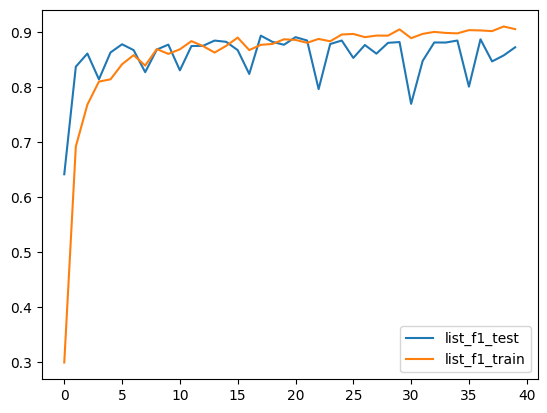

In [ ]:
late_fusion_model = SimpleLateFusionModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(late_fusion_model.parameters(), lr=0.0001)
out = train(late_fusion_model, combined_train_loader, combined_test_loader, criterion, optimizer, num_epochs=40)
plot_performance(out)

In [40]:
image_json = json.load(open("/content/image_json",'r'))

In [56]:
# image_json['Model_0_loss_bce']['output'].keys()
image_json['Model_3_loss_bce']['num_params']

525313

In [65]:
import shutil
# folder = "/content/drive/MyDrive/mlhc_project"
# shutil.copy('/content/text_json',"/content/drive/MyDrive/mlhc_project/text_json")
# shutil.copy('/content/image_json',"/content/drive/MyDrive/mlhc_project/image_json")
# shutil.copy('/content/text_image_json',"/content/drive/MyDrive/mlhc_project/text_image_json")

import pandas as pd

# Define your models
models = ['Model_1537', 'Model_393729', 'Model_459521', 'Model_525313']
# values
value = ['list_acc_test','list_auc_test','list_f1_test']
# Define your loss functions
loss_functions = ['bce', 'focal']

values = [
    [100, 200],
    [150, 250],
    [120, 220],
    [130, 230]
]

for aModelIndex in range(4):
    for aLoss in range(2):
        model_name = f"Model_{aModelIndex}_loss_{loss_functions[aLoss]}"
        values[aModelIndex][aLoss] = max(image_json[model_name]['output']['list_acc_test'])

df_acc = pd.DataFrame(values, columns=loss_functions, index=models)
df_acc.name = 'Accuracy'

for aModelIndex in range(4):
    for aLoss in range(2):
        model_name = f"Model_{aModelIndex}_loss_{loss_functions[aLoss]}"
        values[aModelIndex][aLoss] = max(image_json[model_name]['output']['list_auc_test'])

df_auc = pd.DataFrame(values, columns=loss_functions, index=models)
df_auc.name = 'AUC'

for aModelIndex in range(4):
    for aLoss in range(2):
        model_name = f"Model_{aModelIndex}_loss_{loss_functions[aLoss]}"
        values[aModelIndex][aLoss] = max(image_json[model_name]['output']['list_f1_test'])

df_f1 = pd.DataFrame(values, columns=loss_functions, index=models)
df_f1.name = 'F1'

for aModelIndex in range(4):
    for aLoss in range(2):
        model_name = f"Model_{aModelIndex}_loss_{loss_functions[aLoss]}"
        values[aModelIndex][aLoss] = min(image_json[model_name]['output']['list_loss_test'])

df_loss = pd.DataFrame(values, columns=loss_functions, index=models)
df_loss.name = 'Loss'



In [66]:
df_acc

,bce,focal
Model_1537,0.967117,0.960356
Model_393729,0.967425,0.953596
Model_459521,0.965581,0.935464
Model_525313,0.967425,0.935464


In [62]:
df_auc

,bce,focal
Model_1537,0.958807,0.955379
Model_393729,0.951311,0.953376
Model_459521,0.951158,0.947520
Model_525313,0.951720,0.942760


In [63]:
df_f1

,bce,focal
Model_1537,0.715789,0.600619
Model_393729,0.713514,0.466431
Model_459521,0.687023,0.018605
Model_525313,0.719577,0.009434


In [64]:
df_loss

,bce,focal
Model_1537,0.099143,0.124052
Model_393729,0.104068,0.123745
Model_459521,0.106967,0.124292
Model_525313,0.104448,0.124292


In [ ]:
y_pred_probs = get_predicted_probs(late_fusion_model, combined_test_loader)
y_preds = (np.array(y_pred_probs) > 0.5).astype(int)
late_fusion_roc = roc_auc_score(y_test.numpy(), y_pred_probs)
late_fusion_accuracy = accuracy_score(y_test.numpy(), y_preds)
late_fusion_f1 = f1_score(y_test.numpy(), y_preds)
print(f'Late Fusion ROC: {late_fusion_roc}, Accuracy: {late_fusion_accuracy}, F1: {late_fusion_f1}')

### Attention Model

In [ ]:
class ImageAttentionModule(nn.Module):
    def __init__(self):
        super(ImageAttentionModule, self).__init__()
        self.fc1 = nn.Linear(1536, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.attention = nn.MultiheadAttention(embed_dim=16, num_heads=4, batch_first=True)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        # Reshape x from [batch_size, 256] to [batch_size, 16, 16] for attention
        x = x.view(-1, 16, 16)

        # Apply attention
        attn_output, _ = self.attention(x, x, x)

        # Flatten the output for the final fully connected layer
        x = attn_output.reshape(-1, 256)  # Reshape back to original shape after attention
        return x

class TextAttentionModule(nn.Module):
    def __init__(self):
        super(TextAttentionModule, self).__init__()
        self.fc1 = nn.Linear(4096, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.attention = nn.MultiheadAttention(embed_dim=16, num_heads=4, batch_first=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = x.view(-1, 16, 16)

        # Apply attention
        attn_output, _ = self.attention(x, x, x)

        # Flatten the output for the final fully connected layer
        x = attn_output.reshape(-1, 256)  # Reshape back to original shape after attention
        return x

class AttentionFusionModel(nn.Module):
    def __init__(self):
        super(AttentionFusionModel, self).__init__()
        self.text_attention = TextAttentionModule()
        self.image_attention = ImageAttentionModule()
        self.cross_attention = nn.MultiheadAttention(embed_dim=256, num_heads=4, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.output = nn.Sigmoid()

    def forward(self, combined_data):
        text_data = combined_data[:, :4096]
        image_data = combined_data[:, 4096:]
        text_output = self.text_attention(text_data)
        image_output = self.image_attention(image_data)
        # combined_features = torch.cat((text_output, image_output), dim=1)
        combined_features, _ = self.cross_attention(text_output.unsqueeze(1), image_output.unsqueeze(1), image_output.unsqueeze(1))
        combined_features = combined_features.squeeze(1)
        x = self.fc1(combined_features)

        x = torch.relu(x)

        x = self.fc2(x)
        x = self.output(x)
        return x

In [ ]:
attention_fusion_model = AttentionFusionModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(attention_fusion_model.parameters(), lr=0.0001)
train(attention_fusion_model, combined_train_loader, combined_test_loader, criterion, optimizer, num_epochs=40)

In [ ]:
y_pred_probs = get_predicted_probs(attention_fusion_model, combined_test_loader)
y_preds = (np.array(y_pred_probs) > 0.5).astype(int)
attention_fusion_roc = roc_auc_score(y_test.numpy(), y_pred_probs)
attention_fusion_accuracy = accuracy_score(y_test.numpy(), y_preds)
attention_fusion_f1 = f1_score(y_test.numpy(), y_preds)
print(f'Attention Fusion ROC: {attention_fusion_roc}, Accuracy: {attention_fusion_accuracy}, F1: {attention_fusion_f1}')